# Time Series and Forecasting Models: Facebook Prophet

## 1. Introduction

Prophet is an open source library published by Facebook in 2017 which is built upon scikit-learn time series modelling and automatically detects changes in trends by selecting changepoints from the data. It is an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects, and includes automatic detection for all values. 



## 2. Install/import libraries

In [1]:
# !pip install fbprophet
# !pip install mplfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf
import prophet 
from prophet import Prophet

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

In [3]:
crude = yf.download("CL=F", start="2010-01-01", end="2023-01-15")
crude.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-09,73.470001,76.739998,73.470001,74.629997,74.629997,329290
2023-01-10,74.860001,75.919998,73.839996,75.120003,75.120003,307430
2023-01-11,74.779999,77.839996,74.309998,77.410004,77.410004,350891
2023-01-12,77.699997,79.160004,77.099998,78.389999,78.389999,307705
2023-01-13,78.320000,80.110001,77.970001,79.860001,79.860001,307705


In [5]:
# Create Dataframe for Adjusted Close prices

crude_adj = crude[['Adj Close']].copy()
crude_adj.tail()

,Adj Close
Date,
2023-01-09,74.629997
2023-01-10,75.120003
2023-01-11,77.410004
2023-01-12,78.389999
2023-01-13,79.860001


## 4. Format data for Prophet

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [6]:
# Create a dataframe that complies with Prophet requirements

prophet_crude_adj = crude[['Adj Close']].copy()

In [7]:
# Reset the index back so Dates are no longer indexed
prophet_crude_adj.reset_index(inplace=True)

# Rename the columns for use in FB prophet
prophet_crude_adj.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

prophet_crude_adj.head()

,ds,y
0,2009-12-31,79.360001
1,2010-01-04,81.510002
2,2010-01-05,81.769997
3,2010-01-06,83.180000
4,2010-01-07,82.660004


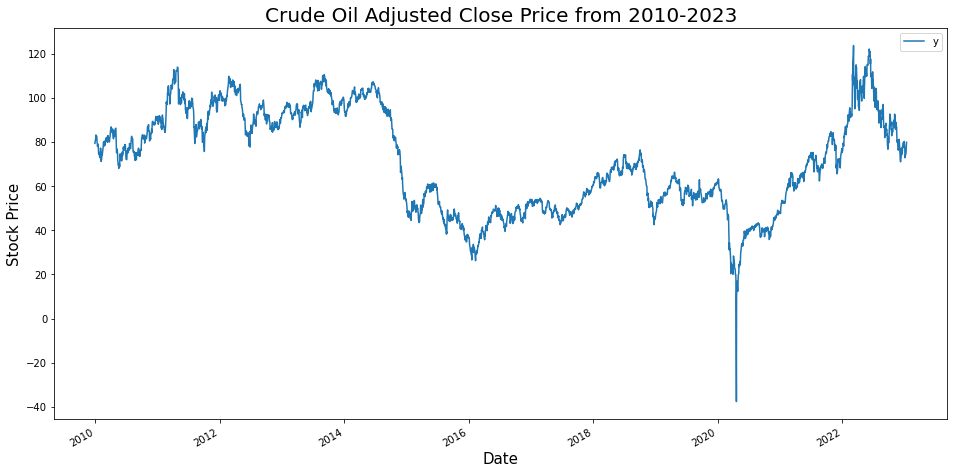

In [8]:
# Plot Adjusted Close price
pd.plotting.register_matplotlib_converters()
ax = prophet_crude_adj.set_index('ds').plot(figsize=(16,8))
ax.set_title('Crude Oil Adjusted Close Price from 2010-2023', color = 'black', fontsize = 20)
ax.set_ylabel('Stock Price', color = 'black', fontsize = 15)
ax.set_xlabel('Date', color = 'black', fontsize = 15)

plt.show()

## 5. Modelling

Prophet follows the sklearn model API. We create an instance of the Prophet class and then call its fit and predict methods.

### 5.1 Fit and train the model

Fit the model by instantiating a new Prophet object. Any settings to the forecasting procedure are passed into the constructor.

In [9]:
# Instantiate model and pass seasonality setting

m = Prophet(daily_seasonality = True)

Call the fit method and pass in the dataframe of dates and prices.



In [10]:
# fit the model

m.fit(prophet_crude_adj)

04:04:26 - cmdstanpy - INFO - Chain [1] start processing
04:04:29 - cmdstanpy - INFO - Chain [1] done processing


### 5.2 Create future dates to forecast

Predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method Prophet.make_future_dataframe.

In [15]:
# create a dataframe containing future dates to be forecast 
future = m.make_future_dataframe(periods=730, freq='D')     
future.tail()

,ds
4007,2025-01-08
4008,2025-01-09
4009,2025-01-10
4010,2025-01-11
4011,2025-01-12


### 5.3 Predictions

Forecasting future values in the dataframe containing dates for prediction.

In [16]:
# Pass the dataframe to the model with dates to predict future values
forecast = m.predict(future)

### Plot Actual vs Predicted prices

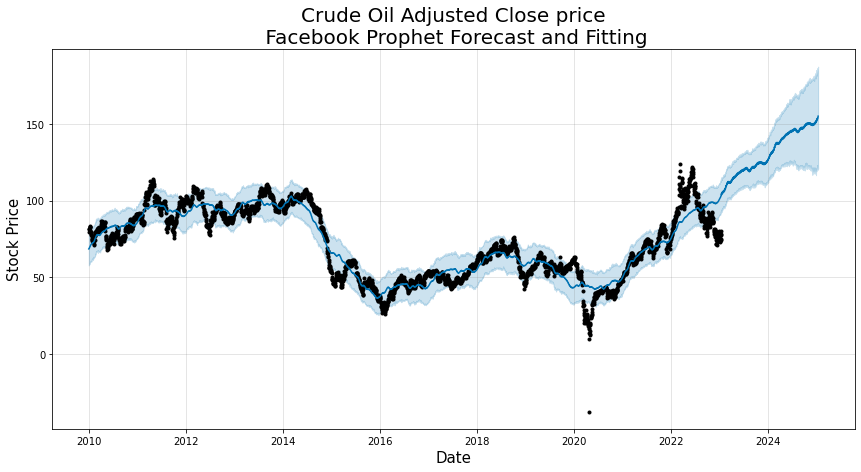

In [17]:
# Plot Forecast and Actual prices  
m.plot(forecast, uncertainty=True, figsize=(12,6))
plt.title('Crude Oil Adjusted Close price\n Facebook Prophet Forecast and Fitting', color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

In the above plot:
*   Blue line = Forecasted values
*   Black dots = Observed (actual) values
*   Blue-shaded region = Confidence interval


### Trend Changepoints

Time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

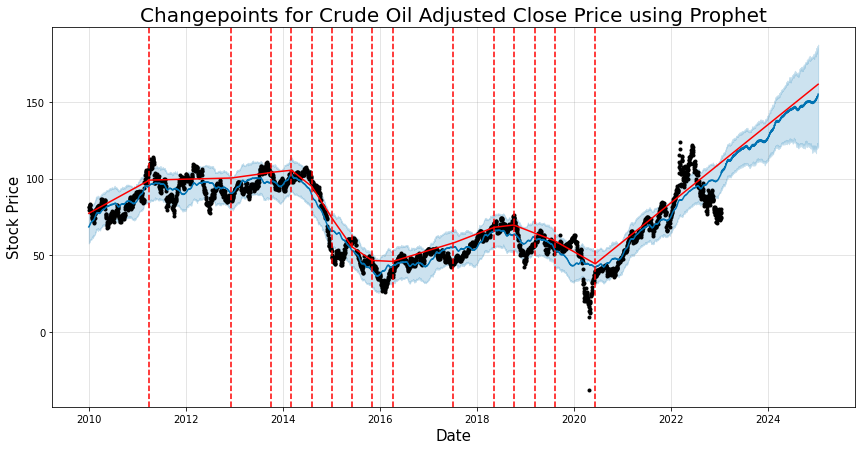

In [18]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast, figsize=(12,6))
# the change points are added to our plot 
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title("Changepoints for Crude Oil Adjusted Close Price using Prophet", color = 'black', fontsize = 20)
plt.xlabel("Date", color = 'black', fontsize = 15)
plt.ylabel("Stock Price", color = 'black', fontsize = 15)
plt.show()

By default, Prophet adds 25 changepoints into the initial 80% of the data set. Taking a look at the possible changepoints (dotted red lines) in the above chart, we can see they fit quite well with some of the highs and lows.

### Plot magnitudes of changepoints

Prophet will also let us take a look at the magnitudes of these possible changepoints.

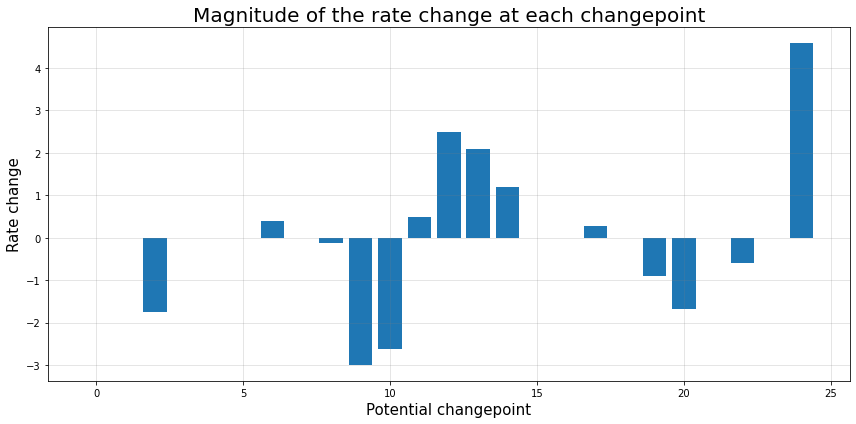

In [19]:
deltas = m.params['delta'].mean(0) 
fig = plt.figure(facecolor='w', figsize=(12,6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.title('Magnitude of the rate change at each changepoint', color = 'black', fontsize = 20)
ax.set_ylabel('Rate change', color = 'black', fontsize = 15)
ax.set_xlabel('Potential changepoint', color = 'black', fontsize = 15)
fig.tight_layout()

We can see that the red dotted lines in the plot of changepoints correspond with plot above of the magnitude of the rate change at each changepoint. Even though we have a lot of places where the rate can possibly change, because of the sparse prior, most of these changepoints go unused.

### Extract changepoints

If we want to use something like this in a model, we need a way of extracting changepoint data.

In [20]:
# View changepoints

m.changepoints

105    2010-06-03
210    2010-11-01
315    2011-04-01
420    2011-08-31
525    2012-02-01
630    2012-07-02
735    2012-12-03
840    2013-05-06
945    2013-10-03
1050   2014-03-06
1155   2014-08-05
1260   2015-01-05
1364   2015-06-04
1469   2015-11-02
1574   2016-04-05
1679   2016-09-01
1784   2017-02-06
1889   2017-07-07
1994   2017-12-05
2099   2018-05-08
2204   2018-10-05
2309   2019-03-11
2414   2019-08-08
2519   2020-01-08
2624   2020-06-09
Name: ds, dtype: datetime64[ns]

### Plot components of the forecasts

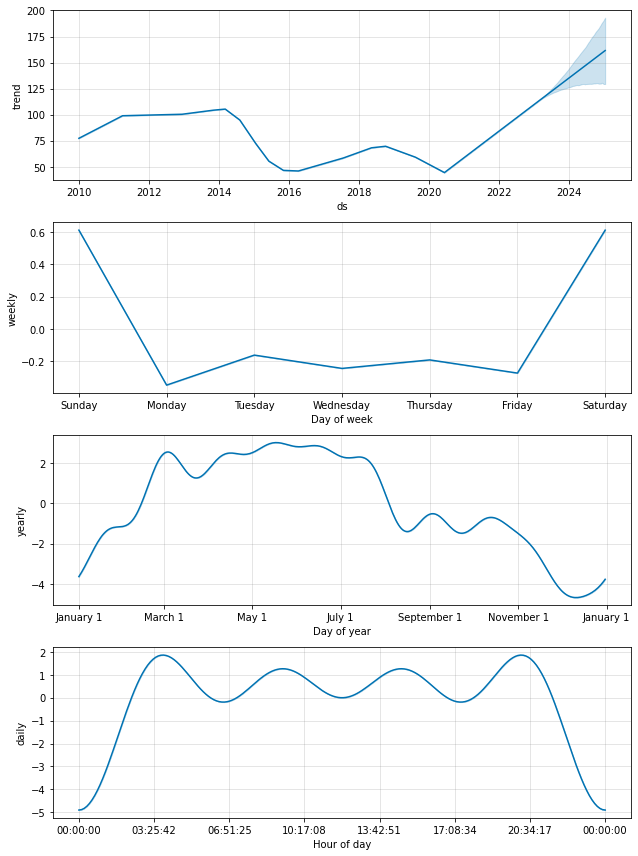

In [21]:
# Plot the trend, weekly, yearly and daily components

m.plot_components(forecast)
plt.show()

Our data has some seasonal information present. Based on the estimated trends, we can see from the yearly subplot that, usually, the stock price is highest in mid-August and, according to the weekly subplot, mostly on Fridays. Inevitably, the daily subplot shows that the stock price fluctuates throughout the day.

Finally, the trend subplot shows an upward trend including an increase in the stock price between mid 2020 and beginning of 2022). The dataset only contained data up to the end of 2019 so this prediction does not reflect any impact of Covid-19.